In [ ]:
# 05. Feature Engineering for CDR Analysis

**Objective**: Create meaningful features from raw CDR data for advanced analytics
**Strategy**: Work with views and small aggregated results only
**Time Budget**: 45 minutes max


In [1]:
# Standard imports and setup
import sys
sys.path.append('/home/jovyan/work/batch/jupyter/notebooks/work/scripts')
from spark_init import init_spark
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from pyspark.sql import functions as F, types as T
from pyspark.sql.window import Window
from pyspark.sql.types import *
from datetime import datetime, timedelta
import json

# Initialize Spark
spark = init_spark("Feature Engineering - AT CDR")
print("✅ SparkSession initialized")
print(f"Spark Version: {spark.version}")
print(f"Warehouse Location: {spark.conf.get('spark.sql.warehouse.dir')}")

# Use the database
spark.sql("USE at_cdr_analysis")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create temp views
cdr_raw = spark.read.parquet("/user/hive/warehouse/Raw/raw_cdr_enhanced/")
cdr_raw.createOrReplaceTempView("fact_cdr_raw")

customers = spark.read.parquet("/user/hive/warehouse/Raw/customer_dim_enhanced/")
customers.createOrReplaceTempView("dim_customers")

print("✅ Environment ready for feature engineering")
print(f"📊 Total CDR records: {cdr_raw.count():,}")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/08 03:31:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/08 03:31:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


✅ SparkSession initialized (App: Feature Engineering - AT CDR, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized
Spark Version: 3.5.1
Warehouse Location: hdfs://namenode:9000/user/hive/warehouse


25/07/08 03:31:58 WARN HiveConf: HiveConf of name hive.metastore.event.db.notification.api.auth does not exist
25/07/08 03:32:13 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/07/08 03:32:28 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/07/08 03:32:43 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/07/08 03:32:58 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/07/08 03:33:13 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/07/08 

✅ Environment ready for feature engineering


📊 Total CDR records: 768,359,379


In [4]:
# ## 1. Time-Based Features

# %%
print("🕐 Creating time-based features...")

# Create time features view
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW time_features AS
SELECT 
    customer_id,
    timestamp,
    -- Basic time features
    YEAR(timestamp) as year,
    MONTH(timestamp) as month,
    DAY(timestamp) as day,
    HOUR(timestamp) as hour,
    MINUTE(timestamp) as minute,
    DAYOFWEEK(timestamp) as day_of_week,
    WEEKOFYEAR(timestamp) as week_of_year,
    
    -- Derived time features
    CASE 
        WHEN HOUR(timestamp) BETWEEN 0 AND 5 THEN 'Night'
        WHEN HOUR(timestamp) BETWEEN 6 AND 11 THEN 'Morning'
        WHEN HOUR(timestamp) BETWEEN 12 AND 17 THEN 'Afternoon'
        WHEN HOUR(timestamp) BETWEEN 18 AND 23 THEN 'Evening'
    END as time_period,
    
    CASE 
        WHEN DAYOFWEEK(timestamp) IN (1, 7) THEN 'Weekend'
        ELSE 'Weekday'
    END as day_type,
    
    CASE 
        WHEN HOUR(timestamp) BETWEEN 9 AND 17 AND DAYOFWEEK(timestamp) NOT IN (1, 7) THEN 'Business Hours'
        ELSE 'Non-Business Hours'
    END as business_hours,
    
    -- Special periods
    CASE 
        WHEN DATE(timestamp) BETWEEN '2025-03-20' AND '2025-04-02' THEN 'Ramadan'
        WHEN DATE(timestamp) BETWEEN '2025-06-15' AND '2025-06-19' THEN 'Baccalaureate'
        WHEN DATE(timestamp) = '2025-07-19' THEN 'Bac Results'
        ELSE 'Normal'
    END as special_period
    
FROM fact_cdr_raw
""")

# Sample time features
print("📊 Sample time features:")
spark.sql("""
    SELECT time_period, day_type, business_hours, COUNT(*) as count
    FROM time_features
    GROUP BY time_period, day_type, business_hours
    ORDER BY count DESC
""").show(10)


🕐 Creating time-based features...
📊 Sample time features:


+-----------+--------+------------------+---------+
|time_period|day_type|    business_hours|    count|
+-----------+--------+------------------+---------+
|    Evening| Weekday|Non-Business Hours|212351501|
|  Afternoon| Weekday|    Business Hours|169549709|
|    Morning| Weekday|    Business Hours| 98502877|
|    Evening| Weekend|Non-Business Hours| 91103996|
|  Afternoon| Weekend|Non-Business Hours| 72898439|
|    Morning| Weekend|Non-Business Hours| 64094021|
|    Morning| Weekday|Non-Business Hours| 45071765|
|      Night| Weekday|Non-Business Hours| 10038220|
|      Night| Weekend|Non-Business Hours|  4748851|
+-----------+--------+------------------+---------+



In [5]:
# ## 2. Customer Behavior Features

# %%
print("\n👥 Creating customer behavior features...")

# Customer usage patterns
customer_features = spark.sql("""
WITH customer_metrics AS (
    SELECT 
        customer_id,
        -- Usage intensity
        COUNT(*) as total_sessions,
        COUNT(DISTINCT DATE(timestamp)) as active_days,
        COUNT(DISTINCT HOUR(timestamp)) as active_hours,
        COUNT(DISTINCT wilaya_code) as location_diversity,
        
        -- Data usage patterns
        SUM(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) as total_data_mb,
        AVG(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END) as avg_data_mb,
        MAX(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) as max_data_mb,
        STDDEV(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END) as std_data_mb,
        
        -- Session patterns
        AVG(CASE WHEN cdr_type = 'DATA' THEN duration_minutes ELSE NULL END) as avg_duration,
        SUM(CASE WHEN cdr_type = 'DATA' THEN duration_minutes ELSE 0 END) as total_duration,
        
        -- Time preferences
        SUM(CASE WHEN HOUR(timestamp) BETWEEN 0 AND 5 THEN 1 ELSE 0 END) as night_sessions,
        SUM(CASE WHEN HOUR(timestamp) BETWEEN 9 AND 17 THEN 1 ELSE 0 END) as business_sessions,
        SUM(CASE WHEN HOUR(timestamp) BETWEEN 20 AND 23 THEN 1 ELSE 0 END) as evening_sessions,
        
        -- Anomaly indicators
        SUM(CASE WHEN cdr_type = 'ANOMALY' THEN 1 ELSE 0 END) as anomaly_count,
        SUM(CASE WHEN cdr_type = 'OUTAGE' THEN 1 ELSE 0 END) as outage_count
        
    FROM fact_cdr_raw
    GROUP BY customer_id
)
SELECT 
    customer_id,
    
    -- Basic metrics
    total_sessions,
    active_days,
    active_hours,
    location_diversity,
    
    -- Usage intensity category
    CASE 
        WHEN total_data_mb > 100000 THEN 'Heavy'
        WHEN total_data_mb > 50000 THEN 'Medium'
        WHEN total_data_mb > 10000 THEN 'Light'
        ELSE 'Very Light'
    END as usage_category,
    
    -- Engagement score (0-100)
    ROUND(
        (active_days / 122.0 * 30) +  -- Days active (30%)
        (active_hours / 24.0 * 20) +   -- Hour diversity (20%)
        (LEAST(total_sessions / 1000.0, 1) * 30) +  -- Session frequency (30%)
        (location_diversity / 58.0 * 20)  -- Location diversity (20%)
    , 2) as engagement_score,
    
    -- Time preference
    CASE 
        WHEN night_sessions > business_sessions AND night_sessions > evening_sessions THEN 'Night Owl'
        WHEN business_sessions > night_sessions AND business_sessions > evening_sessions THEN 'Business User'
        WHEN evening_sessions > night_sessions AND evening_sessions > business_sessions THEN 'Evening User'
        ELSE 'Mixed'
    END as time_preference,
    
    -- Risk indicators
    anomaly_count,
    outage_count,
    ROUND(100.0 * anomaly_count / NULLIF(total_sessions, 0), 2) as anomaly_rate,
    
    -- Data usage features
    total_data_mb,
    avg_data_mb,
    max_data_mb,
    ROUND(std_data_mb, 2) as data_variability,
    
    -- Session features
    avg_duration,
    total_duration,
    ROUND(total_data_mb / NULLIF(total_duration, 1), 2) as mb_per_minute
    
FROM customer_metrics
WHERE total_sessions > 5  -- Filter out very low activity customers to reduce data size
""")

# Save customer features as temp view
customer_features.createOrReplaceTempView("customer_features")

# Show sample
print("📊 Customer feature summary:")
customer_features.groupBy("usage_category").agg(
    F.count("*").alias("customers"),
    F.round(F.avg("engagement_score"), 2).alias("avg_engagement_score"),
    F.round(F.avg("total_data_mb")/1024, 2).alias("avg_data_gb")
).orderBy("customers", ascending=False).show()



👥 Creating customer behavior features...
📊 Customer feature summary:


+--------------+---------+--------------------+-----------+
|usage_category|customers|avg_engagement_score|avg_data_gb|
+--------------+---------+--------------------+-----------+
|         Heavy|   387888|               79.88|     291.16|
|        Medium|   115131|               79.75|      73.43|
|         Light|    16893|               79.72|      30.35|
+--------------+---------+--------------------+-----------+



In [9]:
# 3. Network Performance Features

print("\n📡 Creating network performance features...")

network_features = spark.sql("""
WITH cell_metrics AS (
    SELECT 
        connection_id                           AS cell_id,
        wilaya_code,
        
        -- Load metrics
        COUNT(*)                                AS total_sessions,
        COUNT(DISTINCT customer_id)             AS unique_users,
        COUNT(DISTINCT DATE(timestamp))         AS active_days,
        
        -- Performance metrics
        AVG(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END) AS avg_data_mb,
        PERCENTILE_APPROX(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END, 0.5)
                                                AS median_data_mb,
        MAX(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END)
                                                AS max_data_mb,
        
        -- Quality indicators
        AVG(CASE WHEN session_quality = 'GOOD' THEN 1 ELSE 0 END) * 100 AS good_quality_pct,
        AVG(CASE WHEN session_quality = 'POOR' THEN 1 ELSE 0 END) * 100 AS poor_quality_pct,
        
        -- Problem indicators
        SUM(CASE WHEN cdr_type = 'ANOMALY' THEN 1 ELSE 0 END)           AS anomaly_count,
        SUM(CASE WHEN cdr_type = 'OUTAGE' THEN 1 ELSE 0 END)           AS outage_count,
        
        -- Peak‐hour load
        MAX(hourly_load)                                              AS peak_hour_load
    FROM (
        SELECT
          *,
          COUNT(*) OVER (PARTITION BY connection_id, DATE(timestamp), HOUR(timestamp)) AS hourly_load
        FROM fact_cdr_raw
    ) t
    GROUP BY connection_id, wilaya_code
)
SELECT 
    cell_id,
    wilaya_code,
    
    -- Load category
    CASE 
      WHEN total_sessions > 100000 THEN 'High Load'
      WHEN total_sessions >  50000 THEN 'Medium Load'
      WHEN total_sessions >  10000 THEN 'Low Load'
      ELSE                                'Very Low Load'
    END AS load_category,
    
    -- Performance score (0–100)
    ROUND(
      good_quality_pct * 0.4
      + (1 - LEAST(anomaly_count/total_sessions*100,1)) * 30
      + (LEAST(unique_users/1000,1)*100) * 0.3
    ,2) AS performance_score,
    
    -- Stress level
    CASE 
      WHEN peak_hour_load > 10000 THEN 'Critical'
      WHEN peak_hour_load >  5000 THEN 'High'
      WHEN peak_hour_load >  1000 THEN 'Medium'
      ELSE                                'Low'
    END AS stress_level,
    
    total_sessions,
    unique_users,
    ROUND(avg_data_mb,2) AS avg_data_mb,
    ROUND(good_quality_pct,2) AS good_quality_pct,
    anomaly_count,
    outage_count
    
FROM cell_metrics
WHERE total_sessions > 100  -- drop very low‐activity cells
""")

network_features.createOrReplaceTempView("network_features")

print("📊 Network performance summary:")
spark.sql("""
  SELECT load_category, stress_level, COUNT(*) AS cell_count
  FROM network_features
  GROUP BY load_category, stress_level
  ORDER  BY cell_count DESC
""").show(10)



📡 Creating network performance features...
📊 Network performance summary:


+-------------+------------+----------+
|load_category|stress_level|cell_count|
+-------------+------------+----------+
|Very Low Load|         Low|    518728|
+-------------+------------+----------+



In [10]:
# ## 4. Temporal Aggregation Features

# %%
print("\n📅 Creating temporal aggregation features...")

# Daily aggregated features
daily_features = spark.sql("""
SELECT 
    DATE(timestamp) as date,
    wilaya_code,
    service_type,
    
    -- Volume metrics
    COUNT(*) as daily_sessions,
    COUNT(DISTINCT customer_id) as daily_active_users,
    SUM(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) as daily_data_mb,
    
    -- Quality metrics
    AVG(CASE WHEN session_quality = 'GOOD' THEN 1 ELSE 0 END) * 100 as daily_good_quality_pct,
    
    -- Problem metrics
    SUM(CASE WHEN cdr_type = 'ANOMALY' THEN 1 ELSE 0 END) as daily_anomalies,
    SUM(CASE WHEN cdr_type = 'OUTAGE' THEN 1 ELSE 0 END) as daily_outages,
    
    -- Peak hour
    MAX(hourly_sessions) as peak_hour_sessions,
    
    -- Growth metrics (will be calculated with window functions)
    LAG(COUNT(*), 1) OVER (PARTITION BY wilaya_code, service_type ORDER BY DATE(timestamp)) as prev_day_sessions,
    LAG(COUNT(*), 7) OVER (PARTITION BY wilaya_code, service_type ORDER BY DATE(timestamp)) as week_ago_sessions
    
FROM (
    SELECT *,
           COUNT(*) OVER (PARTITION BY DATE(timestamp), HOUR(timestamp), wilaya_code, service_type) as hourly_sessions
    FROM fact_cdr_raw
) t
GROUP BY DATE(timestamp), wilaya_code, service_type
""")

# Calculate growth rates
daily_features_enriched = daily_features.select(
    "*",
    F.round(((F.col("daily_sessions") - F.col("prev_day_sessions")) / F.col("prev_day_sessions") * 100), 2).alias("daily_growth_pct"),
    F.round(((F.col("daily_sessions") - F.col("week_ago_sessions")) / F.col("week_ago_sessions") * 100), 2).alias("weekly_growth_pct")
)

# Save as temp view
daily_features_enriched.createOrReplaceTempView("daily_features")

# Show recent trends
print("📊 Recent daily trends (last 7 days):")
spark.sql("""
    SELECT 
        date,
        SUM(daily_sessions) as total_sessions,
        SUM(daily_active_users) as total_users,
        ROUND(SUM(daily_data_mb)/1024, 2) as total_gb,
        ROUND(AVG(daily_growth_pct), 2) as avg_daily_growth
    FROM daily_features
    WHERE date >= DATE_SUB(CURRENT_DATE, 7)
    GROUP BY date
    ORDER BY date DESC
    LIMIT 7
""").show()



📅 Creating temporal aggregation features...
📊 Recent daily trends (last 7 days):


+----------+--------------+-----------+----------+----------------+
|      date|total_sessions|total_users|  total_gb|avg_daily_growth|
+----------+--------------+-----------+----------+----------------+
|2025-07-19|       7732002|     519912|1232784.39|           12.85|
|2025-07-18|       6598808|     519903|1028534.57|           17.92|
|2025-07-17|       5677033|     519866| 907721.17|            0.11|
|2025-07-16|       5670031|     519861| 906332.48|           -0.24|
|2025-07-15|       5675049|     519859| 907023.95|            0.13|
|2025-07-14|       5673888|     519862| 907677.12|           -6.09|
|2025-07-13|       6004113|     519898|  941611.0|            -7.8|
+----------+--------------+-----------+----------+----------------+



In [14]:
# %%
import json

# Turn off broadcast joins so Spark will use shuffle joins instead of building giant in-memory hash tables:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

print("\n💾 Exporting key features in Parquet...")

# 1) Customer segments (bounded LIMIT, active customers only)
print("Preparing customer segments...")
customer_segments_sdf = spark.sql("""
    SELECT 
        cf.customer_id,
        cf.usage_category,
        cf.engagement_score,
        cf.time_preference,
        ROUND(cf.total_data_mb/1024, 2) AS total_data_gb,
        cf.anomaly_rate,
        c.service_type,
        c.customer_type,
        c.wilaya_name,
        c.offer_price
    FROM customer_features cf
    JOIN dim_customers c 
      ON cf.customer_id = c.customer_id
    WHERE cf.total_sessions > 10
    LIMIT 50000
""")

# Write as Parquet (one file per Spark partition; avoids the single-file NPE)
customer_segments_sdf.write \
    .mode("overwrite") \
    .parquet("/mnt/d/customer_segments.parquet")

print("✅ Customer segments written to /mnt/d/customer_segments.parquet")

# 2) Network performance summary (already aggregated)
print("Preparing network summary...")
network_summary_sdf = spark.sql("""
    SELECT 
        wilaya_code,
        COUNT(DISTINCT cell_id)         AS cell_count,
        ROUND(AVG(performance_score),2) AS avg_performance,
        SUM(CASE WHEN stress_level IN ('Critical','High') THEN 1 ELSE 0 END) AS stressed_cells,
        SUM(anomaly_count)              AS total_anomalies,
        SUM(outage_count)               AS total_outages
    FROM network_features
    GROUP BY wilaya_code
""")

network_summary_sdf.write \
    .mode("overwrite") \
    .parquet("/mnt/d/network_performance.parquet")

print("✅ Network performance written to /mnt/d/network_performance.parquet")

# 3) Feature statistics (JSON)
print("Calculating feature statistics...")
feature_stats = {
    "total_customers_analyzed": int(spark.sql("SELECT COUNT(DISTINCT customer_id) FROM customer_features").first()[0]),
    "total_cells_analyzed":    int(spark.sql("SELECT COUNT(DISTINCT cell_id)     FROM network_features").first()[0]),
    "date_range": {
        "start": str(spark.sql("SELECT MIN(DATE(timestamp)) FROM fact_cdr_raw").first()[0]),
        "end":   str(spark.sql("SELECT MAX(DATE(timestamp)) FROM fact_cdr_raw").first()[0])
    },
    "feature_categories": {
        "time_based":        ["hour","day_of_week","time_period","special_period"],
        "customer_behavior": ["usage_category","engagement_score","time_preference","anomaly_rate"],
        "network_performance":["load_category","performance_score","stress_level"],
        "temporal":          ["daily_sessions","daily_active_users","daily_anomalies"]
    }
}

with open("/mnt/d/feature_statistics.json", "w") as f:
    json.dump(feature_stats, f, indent=2)

print("✅ Saved feature statistics to /mnt/d/feature_statistics.json")



💾 Exporting key features in Parquet...
Preparing customer segments...


✅ Customer segments written to /mnt/d/customer_segments.parquet
Preparing network summary...


✅ Network performance written to /mnt/d/network_performance.parquet
Calculating feature statistics...


✅ Saved feature statistics to /mnt/d/feature_statistics.json



📊 Creating feature visualizations...


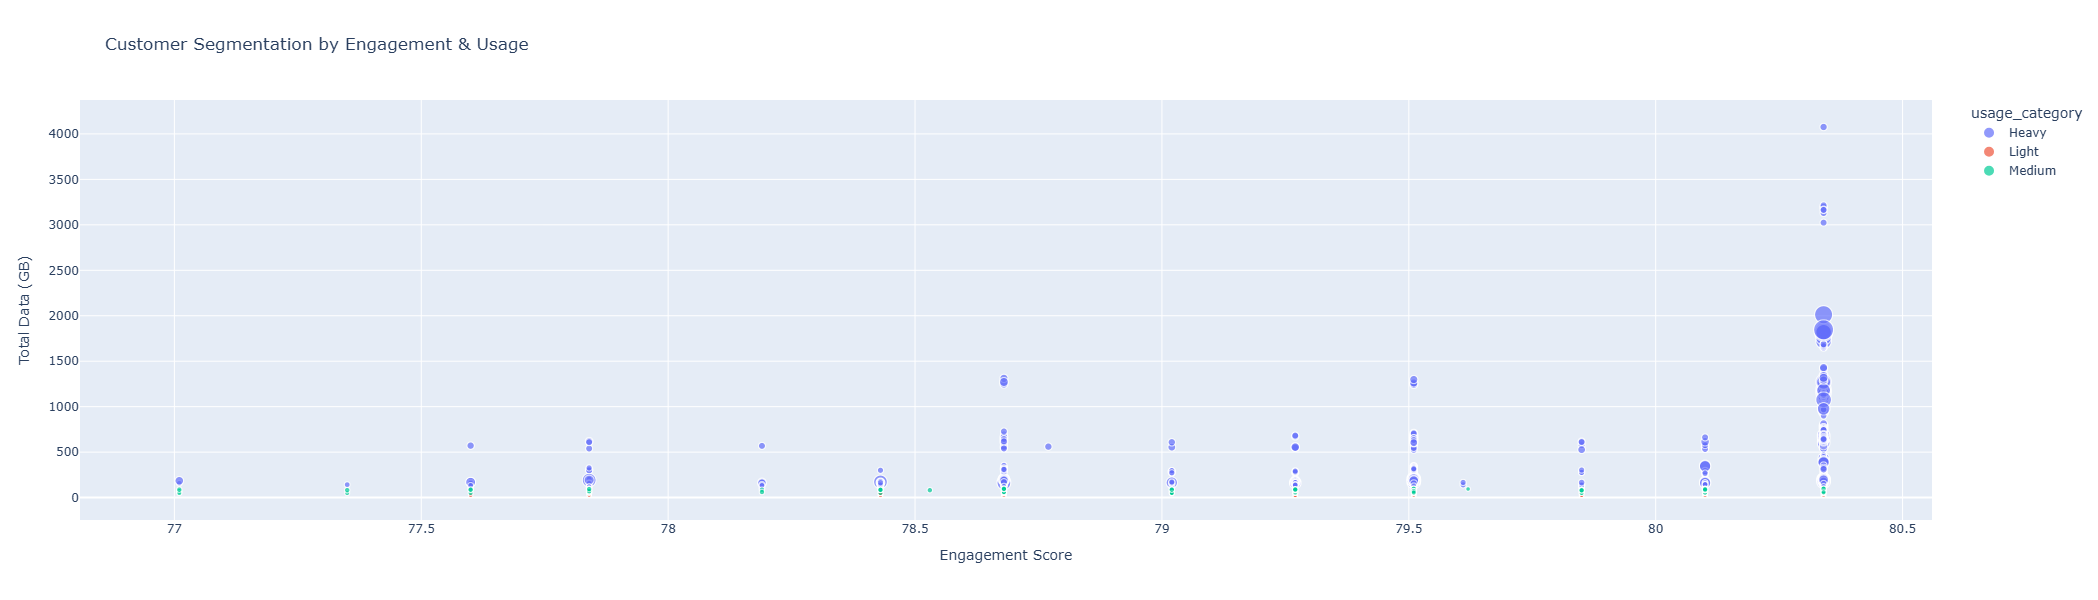

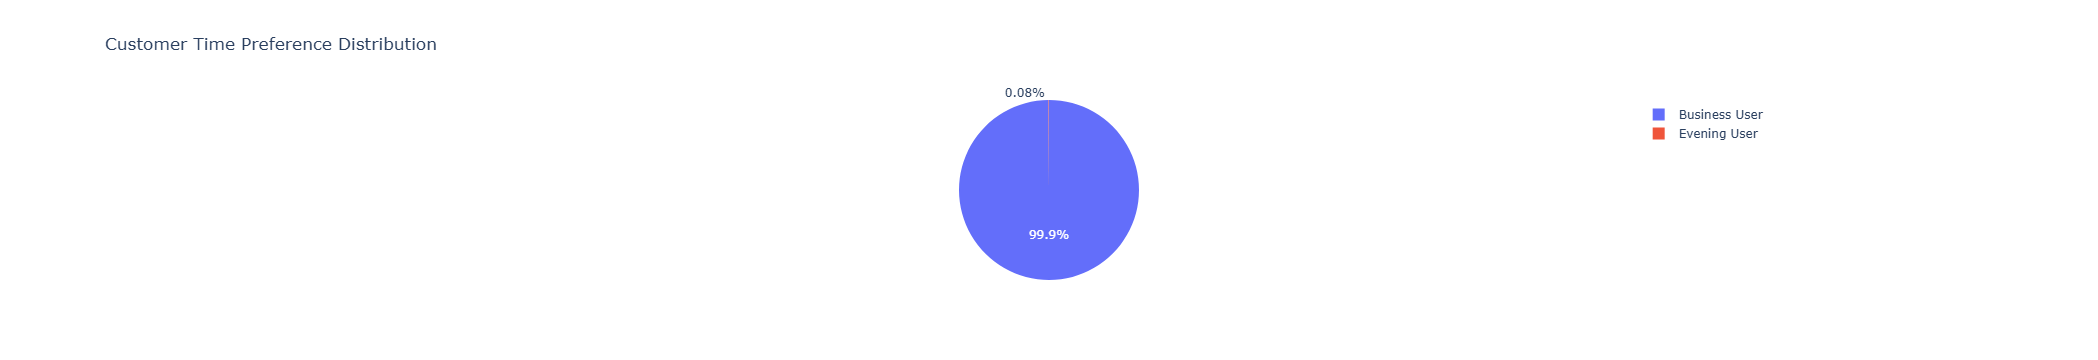

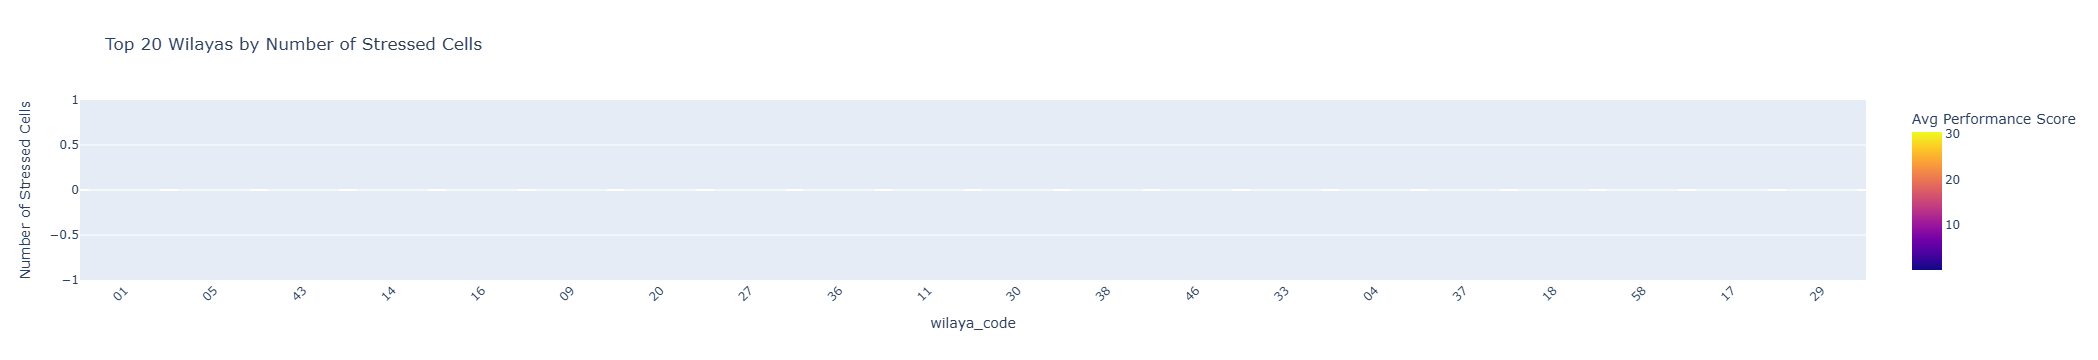


🎉 FEATURE ENGINEERING & VISUALIZATION COMPLETE!

✅ Features Created:
  - Time-based features (hour, day_of_week, special_period)
  - Customer behavior (usage_category, engagement_score, anomaly_rate)
  - Network performance (performance_score, stress_level, outages)
  - Aggregations by wilaya, cell, and day

📊 Key Insights:
  - 519,912 total customers in features
  - 518,728 total cell towers in features
  - Heavy users: 3,712
  - Wilayas under stress: 0

💾 Exported Files:
  - /mnt/d/customer_segments.parquet
  - /mnt/d/network_performance.parquet
  - /mnt/d/feature_statistics.json

🚀 Ready for segmentation, network optimization, modeling & dashboards!


In [16]:
# %%
import json
import plotly.express as px

print("\n📊 Creating feature visualizations...")

# 1) Read the Parquet files back in as Spark DataFrames
customer_segments_sdf = spark.read.parquet("/mnt/d/customer_segments.parquet")
network_summary_sdf   = spark.read.parquet("/mnt/d/network_performance.parquet")

# 2) Move to Pandas for plotting
#    (we only pull down a sample of up to 5k rows for performance)
customer_segments = (
    customer_segments_sdf
      .limit(5000)
      .toPandas()
)
network_summary = network_summary_sdf.toPandas()

# 3) Customer segmentation scatter
fig = px.scatter(
    customer_segments,
    x="engagement_score",
    y="total_data_gb",
    color="usage_category",
    size="offer_price",
    hover_data=["customer_id", "service_type"],
    title="Customer Segmentation by Engagement & Usage",
    labels={
        "total_data_gb": "Total Data (GB)",
        "engagement_score": "Engagement Score"
    }
)
fig.update_layout(height=600)
fig.show()

# 4) Time preference pie
time_pref_dist = customer_segments["time_preference"].value_counts()
fig = px.pie(
    names=time_pref_dist.index,
    values=time_pref_dist.values,
    title="Customer Time Preference Distribution"
)
fig.show()

# 5) Network stress bar chart (top 20 wilayas)
top20 = network_summary.nlargest(20, "stressed_cells")
fig = px.bar(
    top20,
    x="wilaya_code",
    y="stressed_cells",
    color="avg_performance",
    title="Top 20 Wilayas by Number of Stressed Cells",
    labels={
        "stressed_cells": "Number of Stressed Cells",
        "avg_performance": "Avg Performance Score"
    }
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

# 6) Summary printout
print("\n" + "="*50)
print("🎉 FEATURE ENGINEERING & VISUALIZATION COMPLETE!")
print("="*50)

stats = json.load(open("/mnt/d/feature_statistics.json"))
print(f"\n✅ Features Created:")
print("  - Time-based features (hour, day_of_week, special_period)")
print("  - Customer behavior (usage_category, engagement_score, anomaly_rate)")
print("  - Network performance (performance_score, stress_level, outages)")
print("  - Aggregations by wilaya, cell, and day")

print(f"\n📊 Key Insights:")
print(f"  - {stats['total_customers_analyzed']:,} total customers in features")
print(f"  - {stats['total_cells_analyzed']:,} total cell towers in features")
print(f"  - Heavy users: {len(customer_segments[customer_segments['usage_category']=='Heavy']):,}")
print(f"  - Wilayas under stress: {len(network_summary[network_summary['stressed_cells']>0])}")

print("\n💾 Exported Files:")
print("  - /mnt/d/customer_segments.parquet")
print("  - /mnt/d/network_performance.parquet")
print("  - /mnt/d/feature_statistics.json")

print("\n🚀 Ready for segmentation, network optimization, modeling & dashboards!")
